# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [38]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

In [2]:
import sklearn
sklearn.__version__

'0.23.2'

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [86]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [344]:
class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
        self.ensemble = []
        self.gammas = []
        pass
    
    def _loss_function(self, y, y_pred):
        return (y - y_pred)**2
    
    def _loss_gradient(self, y, y_pred):
        return -2 * (y - y_pred)
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        
        self.first_prediction_constant = np.mean(y)
        y_new = self.first_prediction_constant * np.ones(len(y))
        
        for i in range(self.n_estimators):
            y_new += self._fit_predict_tree(x, y, y_new)
            # your code here
        
        return self

    def _fit_predict_tree(self, x, y, y_new):
        """
        INPUT:
        x - np.array of shape (k, d)
        таргеты
        y - np.array of shape (k,)
        предсказания текущего ансамбля
        y_new - np.array of shape (k,)
        """
        # Обучаем дерево и возвращаем его предикшн
        y_antigradient = np.array([
            -1*self._loss_gradient(i, j) for i, j in zip(y, y_new)
        ])
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree = tree.fit(x, y_antigradient)
        self.ensemble.append(tree)
        y_pred = tree.predict(x)
        
        # Поиск оптимального lr на текущем шаге
        loss_by_lr = lambda lr : np.mean(self._loss_function(y, y_new + lr*y_pred))
        optimization_res  = minimize(loss_by_lr, 1)
        gamma = optimization_res['x'][0]
        self.gammas.append(gamma)
        
        # your code here
        return gamma * self.learning_rate * y_pred
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = self.first_prediction_constant * np.ones(x.shape[0])
        
        for i in range(self.n_estimators):
            y_pred += self.gammas[i]*self.learning_rate*self.ensemble[i].predict(x)
        
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [345]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [346]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

### Gradient Boosting with gridsearchcv

In [347]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import PredefinedSplit

split_index = [-1]*len(X_train) + [0]*len(X_test)
pds = PredefinedSplit(test_fold = split_index)

In [348]:
np.random.seed(19052019)
g_search = GridSearchCV(
    GradientBoosting(400, 7),
    param_grid={
          'n_estimators' : [200, 250, 275, 300, 350, 400, 500, 600]
        , 'max_depth' : [6, 7, 8, 10]
        , 'learning_rate' : [0.1, 0.2, 0.25, 0.3]
    },
    cv=pds,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=4
)

X, y = np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])
g_search.fit(X, y)

Fitting 1 folds for each of 128 candidates, totalling 128 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 128 out of 128 | elapsed:   49.0s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=GradientBoosting(max_depth=7, n_estimators=400),
             n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.2, 0.25, 0.3],
                         'max_depth': [6, 7, 8, 10],
                         'n_estimators': [200, 250, 275, 300, 350, 400, 500,
                                          600]},
             scoring='neg_mean_squared_error', verbose=2)

In [349]:
g_search.best_params_

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 275}

In [350]:
np.random.seed(19052019)
my_gb = GradientBoosting(
    n_estimators=g_search.best_params_['n_estimators'],
    max_depth=g_search.best_params_['max_depth'],
    learning_rate=g_search.best_params_['learning_rate']
).fit(X_train, y_train)

In [352]:
mean_squared_error(y_test, my_gb.predict(X_test))

9.5875623324


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [36]:
!curl -o flight_delays_train.csv https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv
!curl -o flight_delays_test.csv https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3406k  100 3406k    0     0  4724k      0 --:--:-- --:--:-- --:--:-- 4718k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3210k  100 3210k    0     0  3039k      0  0:00:01  0:00:01 --:--:-- 3039k


In [51]:
from catboost import CatBoostClassifier

In [39]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

- Month, DayofMonth, DayofWeek -- цикличниые фичи, закодируем их синусами и косинусами
- а также оставим Month and DayofWeek как категориальные фичи

In [63]:
train.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,day_of_month_sin,day_of_month_cos
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,6.328745e-17,0.032258
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,-1.580189e-16,0.032258
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,-1.580189e-17,0.032258


In [62]:
train['day_of_month_sin'] = train['DayofMonth'].apply(lambda x : np.sin(2*np.pi*float(x[2:]))/31)
train['day_of_month_cos'] = train['DayofMonth'].apply(lambda x : np.cos(2*np.pi*float(x[2:]))/31)

In [65]:
train['day_of_week_sin'] = train['DayOfWeek'].apply(lambda x : np.sin(2*np.pi*float(x[2:]))/7)
train['day_of_week_cos'] = train['DayOfWeek'].apply(lambda x : np.cos(2*np.pi*float(x[2:]))/7)

In [66]:
train['month_sin'] = train['Month'].apply(lambda x : np.sin(2*np.pi*float(x[2:]))/12)
train['month_cos'] = train['Month'].apply(lambda x : np.cos(2*np.pi*float(x[2:]))/12)

In [80]:
train_feats = [
    'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 
    'day_of_month_sin', 'day_of_month_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'Month', 'DayOfWeek'
]

cat_feats = ['UniqueCarrier', 'Origin', 'Dest', 'Month', 'DayOfWeek']

In [81]:
X_train = train[train_feats]
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

catbst = CatBoostClassifier()
catbst.fit(X_train_part, y_train_part, cat_feats)

Learning rate set to 0.063211
0:	learn: 0.6594477	total: 29.7ms	remaining: 29.6s
1:	learn: 0.6306508	total: 62.4ms	remaining: 31.2s
2:	learn: 0.6068266	total: 84.1ms	remaining: 27.9s
3:	learn: 0.5858746	total: 113ms	remaining: 28.1s
4:	learn: 0.5674242	total: 141ms	remaining: 28s
5:	learn: 0.5517428	total: 174ms	remaining: 28.9s
6:	learn: 0.5399102	total: 188ms	remaining: 26.7s
7:	learn: 0.5295790	total: 226ms	remaining: 28s
8:	learn: 0.5188060	total: 259ms	remaining: 28.6s
9:	learn: 0.5106789	total: 280ms	remaining: 27.7s
10:	learn: 0.5030693	total: 308ms	remaining: 27.7s
11:	learn: 0.4971492	total: 334ms	remaining: 27.5s
12:	learn: 0.4904518	total: 364ms	remaining: 27.6s
13:	learn: 0.4852398	total: 394ms	remaining: 27.8s
14:	learn: 0.4812408	total: 425ms	remaining: 27.9s
15:	learn: 0.4784650	total: 437ms	remaining: 26.9s
16:	learn: 0.4742483	total: 479ms	remaining: 27.7s
17:	learn: 0.4707686	total: 510ms	remaining: 27.8s
18:	learn: 0.4674210	total: 543ms	remaining: 28s
19:	learn: 0.4

162:	learn: 0.4258343	total: 5.95s	remaining: 30.5s
163:	learn: 0.4257348	total: 5.99s	remaining: 30.5s
164:	learn: 0.4256704	total: 6.03s	remaining: 30.5s
165:	learn: 0.4255904	total: 6.07s	remaining: 30.5s
166:	learn: 0.4255484	total: 6.1s	remaining: 30.4s
167:	learn: 0.4254669	total: 6.14s	remaining: 30.4s
168:	learn: 0.4253959	total: 6.18s	remaining: 30.4s
169:	learn: 0.4253796	total: 6.2s	remaining: 30.3s
170:	learn: 0.4253794	total: 6.21s	remaining: 30.1s
171:	learn: 0.4253371	total: 6.25s	remaining: 30.1s
172:	learn: 0.4252654	total: 6.28s	remaining: 30s
173:	learn: 0.4252216	total: 6.32s	remaining: 30s
174:	learn: 0.4251452	total: 6.36s	remaining: 30s
175:	learn: 0.4250339	total: 6.4s	remaining: 29.9s
176:	learn: 0.4249265	total: 6.43s	remaining: 29.9s
177:	learn: 0.4248784	total: 6.48s	remaining: 29.9s
178:	learn: 0.4248508	total: 6.51s	remaining: 29.8s
179:	learn: 0.4247773	total: 6.54s	remaining: 29.8s
180:	learn: 0.4246734	total: 6.58s	remaining: 29.8s
181:	learn: 0.4244809

322:	learn: 0.4145192	total: 12.5s	remaining: 26.2s
323:	learn: 0.4144905	total: 12.5s	remaining: 26.2s
324:	learn: 0.4144560	total: 12.6s	remaining: 26.1s
325:	learn: 0.4143752	total: 12.6s	remaining: 26.1s
326:	learn: 0.4143353	total: 12.7s	remaining: 26.1s
327:	learn: 0.4142872	total: 12.7s	remaining: 26s
328:	learn: 0.4142313	total: 12.7s	remaining: 26s
329:	learn: 0.4142205	total: 12.8s	remaining: 26s
330:	learn: 0.4141762	total: 12.8s	remaining: 25.9s
331:	learn: 0.4141323	total: 12.9s	remaining: 25.9s
332:	learn: 0.4140500	total: 12.9s	remaining: 25.8s
333:	learn: 0.4139457	total: 12.9s	remaining: 25.8s
334:	learn: 0.4138790	total: 13s	remaining: 25.7s
335:	learn: 0.4138330	total: 13s	remaining: 25.7s
336:	learn: 0.4138128	total: 13s	remaining: 25.7s
337:	learn: 0.4136981	total: 13.1s	remaining: 25.6s
338:	learn: 0.4136518	total: 13.1s	remaining: 25.6s
339:	learn: 0.4135978	total: 13.2s	remaining: 25.5s
340:	learn: 0.4135607	total: 13.2s	remaining: 25.5s
341:	learn: 0.4135088	to

485:	learn: 0.4069532	total: 19s	remaining: 20.1s
486:	learn: 0.4069377	total: 19s	remaining: 20s
487:	learn: 0.4069022	total: 19s	remaining: 20s
488:	learn: 0.4068101	total: 19.1s	remaining: 19.9s
489:	learn: 0.4067776	total: 19.1s	remaining: 19.9s
490:	learn: 0.4067309	total: 19.2s	remaining: 19.9s
491:	learn: 0.4067103	total: 19.2s	remaining: 19.8s
492:	learn: 0.4066498	total: 19.2s	remaining: 19.8s
493:	learn: 0.4066298	total: 19.3s	remaining: 19.8s
494:	learn: 0.4065844	total: 19.3s	remaining: 19.7s
495:	learn: 0.4065563	total: 19.4s	remaining: 19.7s
496:	learn: 0.4065075	total: 19.4s	remaining: 19.6s
497:	learn: 0.4064610	total: 19.4s	remaining: 19.6s
498:	learn: 0.4064236	total: 19.5s	remaining: 19.6s
499:	learn: 0.4063853	total: 19.5s	remaining: 19.5s
500:	learn: 0.4063444	total: 19.6s	remaining: 19.5s
501:	learn: 0.4063121	total: 19.6s	remaining: 19.4s
502:	learn: 0.4062799	total: 19.6s	remaining: 19.4s
503:	learn: 0.4062309	total: 19.7s	remaining: 19.4s
504:	learn: 0.4061820	

644:	learn: 0.4005131	total: 25.5s	remaining: 14s
645:	learn: 0.4004768	total: 25.6s	remaining: 14s
646:	learn: 0.4004419	total: 25.6s	remaining: 14s
647:	learn: 0.4003998	total: 25.7s	remaining: 13.9s
648:	learn: 0.4003757	total: 25.7s	remaining: 13.9s
649:	learn: 0.4003493	total: 25.7s	remaining: 13.9s
650:	learn: 0.4003198	total: 25.8s	remaining: 13.8s
651:	learn: 0.4002961	total: 25.8s	remaining: 13.8s
652:	learn: 0.4002463	total: 25.9s	remaining: 13.7s
653:	learn: 0.4001959	total: 25.9s	remaining: 13.7s
654:	learn: 0.4001230	total: 25.9s	remaining: 13.7s
655:	learn: 0.4000715	total: 26s	remaining: 13.6s
656:	learn: 0.4000356	total: 26s	remaining: 13.6s
657:	learn: 0.4000220	total: 26s	remaining: 13.5s
658:	learn: 0.3999969	total: 26.1s	remaining: 13.5s
659:	learn: 0.3999704	total: 26.1s	remaining: 13.5s
660:	learn: 0.3998968	total: 26.2s	remaining: 13.4s
661:	learn: 0.3998662	total: 26.2s	remaining: 13.4s
662:	learn: 0.3998514	total: 26.3s	remaining: 13.4s
663:	learn: 0.3998051	to

806:	learn: 0.3951743	total: 32.3s	remaining: 7.74s
807:	learn: 0.3951253	total: 32.4s	remaining: 7.7s
808:	learn: 0.3950928	total: 32.4s	remaining: 7.66s
809:	learn: 0.3950659	total: 32.5s	remaining: 7.62s
810:	learn: 0.3950108	total: 32.5s	remaining: 7.58s
811:	learn: 0.3949852	total: 32.6s	remaining: 7.54s
812:	learn: 0.3949538	total: 32.6s	remaining: 7.5s
813:	learn: 0.3949419	total: 32.7s	remaining: 7.46s
814:	learn: 0.3948920	total: 32.7s	remaining: 7.42s
815:	learn: 0.3948695	total: 32.8s	remaining: 7.38s
816:	learn: 0.3948248	total: 32.8s	remaining: 7.35s
817:	learn: 0.3947840	total: 32.8s	remaining: 7.31s
818:	learn: 0.3947604	total: 32.9s	remaining: 7.27s
819:	learn: 0.3947101	total: 32.9s	remaining: 7.23s
820:	learn: 0.3946831	total: 33s	remaining: 7.19s
821:	learn: 0.3946299	total: 33s	remaining: 7.15s
822:	learn: 0.3945796	total: 33.1s	remaining: 7.11s
823:	learn: 0.3945499	total: 33.1s	remaining: 7.07s
824:	learn: 0.3945180	total: 33.2s	remaining: 7.04s
825:	learn: 0.3944

969:	learn: 0.3895175	total: 39.4s	remaining: 1.22s
970:	learn: 0.3894764	total: 39.4s	remaining: 1.18s
971:	learn: 0.3894493	total: 39.4s	remaining: 1.14s
972:	learn: 0.3894228	total: 39.5s	remaining: 1.09s
973:	learn: 0.3893511	total: 39.5s	remaining: 1.05s
974:	learn: 0.3893400	total: 39.6s	remaining: 1.01s
975:	learn: 0.3893083	total: 39.6s	remaining: 974ms
976:	learn: 0.3892763	total: 39.7s	remaining: 934ms
977:	learn: 0.3892529	total: 39.7s	remaining: 893ms
978:	learn: 0.3892315	total: 39.8s	remaining: 853ms
979:	learn: 0.3891815	total: 39.8s	remaining: 812ms
980:	learn: 0.3891605	total: 39.9s	remaining: 772ms
981:	learn: 0.3891382	total: 39.9s	remaining: 731ms
982:	learn: 0.3890931	total: 39.9s	remaining: 691ms
983:	learn: 0.3890723	total: 40s	remaining: 650ms
984:	learn: 0.3890387	total: 40s	remaining: 610ms
985:	learn: 0.3890287	total: 40.1s	remaining: 569ms
986:	learn: 0.3890221	total: 40.1s	remaining: 528ms
987:	learn: 0.3889943	total: 40.1s	remaining: 488ms
988:	learn: 0.38

In [82]:
roc_auc_score(y_valid, catbst.predict_proba(X_valid)[:, 1])

0.752724050192267

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [113]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [128]:
# Рекомендации -- это только рекомендации
class dbscan:
    TYPE_CORE_POINT=0
    TYPE_BORDER_POINT=1
    TYPE_NOISE=2
    
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        
        pass
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        self.points = X
        self.is_visited = np.array([False for i in range(X.shape[0])])
        self.cluster = np.array([-1 for i in range(X.shape[0])])
        
        # Счетчик кластеров
        C = -1
        
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        for x_idx in range(self.points.shape[0]):
            if self.is_visited[x_idx] == False:
                # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
                # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
                # (однако она ещё может попасть в какой-то иной кластер)
                # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
                # your code here
                self.is_visited[x_idx] = True
                nbrs = self.range_query(x_idx).tolist()
                if len(nbrs) >= self.min_samples:
                    C += 1
                    self.grow_cluster(x_idx, nbrs, C)
        
        return self.cluster
                

    def grow_cluster(self, root_idx, neighbours, C):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        self.cluster[root_idx] = C
        for nbr in neighbours:
            if self.is_visited[nbr] == False:
                self.is_visited[nbr] = True
                nbrs_of_nbr = self.range_query(nbr).tolist()
                if len(nbrs_of_nbr) >= self.min_samples:
                    neighbours.extend(nbrs_of_nbr)
            if self.cluster[nbr] == -1:
                self.cluster[nbr] = C
                
        pass
            
        
        

    def range_query(self, x_idx):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        dists = self.dist(x_idx)
        nbrs = np.nonzero(dists <= self.eps)[0]
        
        return nbrs
    
    def dist(self, x_idx):
        """
        Метрика расстояния
        Считает расстояние между точкой под индексом x_idx и всеми точками в self.points
        """
        x = self.points[x_idx].reshape(1, -1)
        dists = distance.cdist(x, self.points, metric='euclidean').flatten()
        
        return dists

Проверим себя на простом примере:

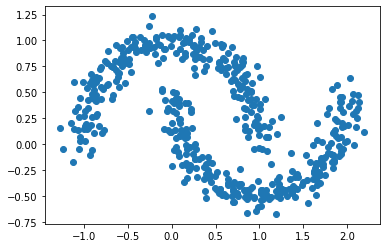

In [129]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

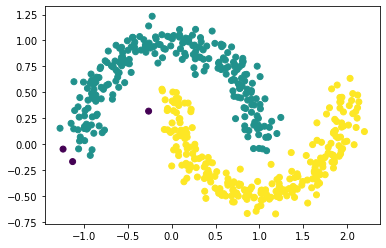

In [134]:
# your code here
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

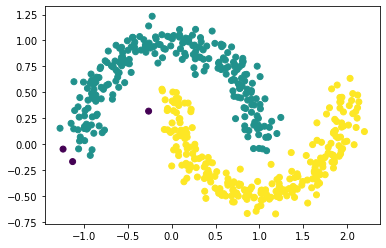

In [135]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [139]:
# your code here
from sklearn import datasets

In [227]:
X, _ = datasets.make_circles(n_samples=10000, noise=0.03, factor=.2)
X = X*25
B, _ = datasets.make_blobs(centers=[[-10, 8], [10, 8], [0, -15]], n_samples=500, cluster_std=0.5)
X = np.concatenate([X, B])

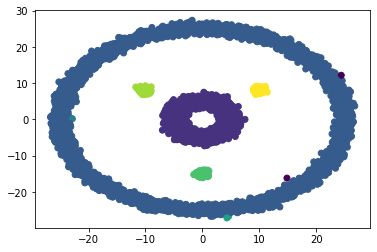

In [228]:
clusters = DBSCAN(eps=1, min_samples=2).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

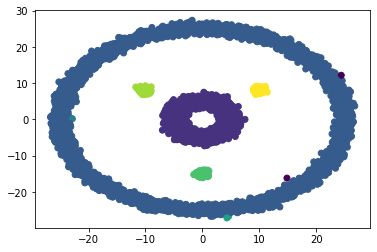

In [229]:
clusters = dbscan(eps=1, min_samples=2).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Или хотя бы что-нибудь такое: 

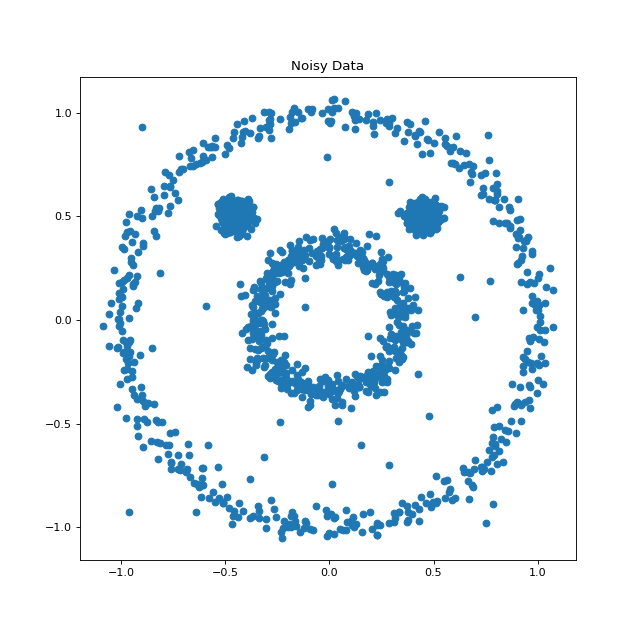

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [136]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 6.61 ms, sys: 75 µs, total: 6.68 ms
Wall time: 5.64 ms


In [137]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 39.2 ms, sys: 85 µs, total: 39.2 ms
Wall time: 34.6 ms
